In [45]:
from copy import copy
from math import *
import numpy as np
from matplotlib import pyplot as plt
import random as rand

rand.seed(1)

In [53]:
# Simulation config
time = 10 # seconds
Td = 0.01 # 100 Hz
points = time/Td

pos_Hz = 5 # Frequency of position update (GPS ~ 5 Hz)
vel_Hz = 10 # Frequency of velocity update (??)
acc_Hz = 20 # frequency of acceleration update (IMU ~ 200 Hz)

pos_sigma = 0.1# Noise distribution of position measurement
vel_sigma = 0.1 # Noise distribution of velocity measurement
acc_sigma = 0.05 # Noise distribution of acceleration measurement

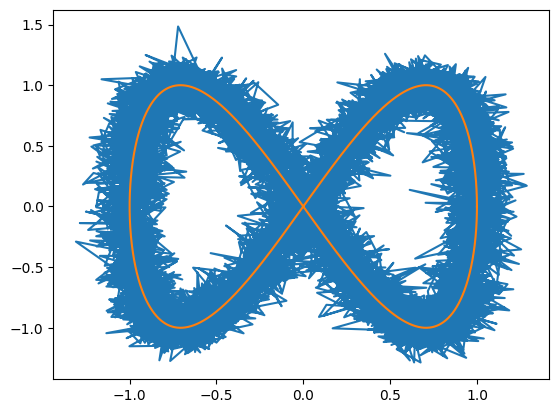

In [7]:

# Generate correct path
pos = []
for i in range(points):
    x = cos(i/points*2*pi)
    y = sin((i/points*2*pi)*2)
    vec = np.array([x,y])
    pos.append(vec)

# Create vel vector

vel = []
prev_pos = None
for xpos in pos:
    if type(prev_pos) == type(None):
        vel.append(np.array([0,0]))
    else:
        vel.append((xpos-prev_pos)/Td)
    prev_pos = xpos

# Create acc vector

acc = []
prev_vel = None
for xvel in vel:
    if type(prev_vel) == type(None):
        acc.append(np.array([0,0]))
    else:
        acc.append((xvel-prev_vel)/Td)
    prev_vel = xvel



# Noisy signals
noisepos = [x + np.array([rand.gauss( 0.0 , pos_sigma ),rand.gauss( 0.0 , pos_sigma )]) for x in pos]
noisevel = [x + np.array([rand.gauss( 0.0 , vel_sigma ),rand.gauss( 0.0 , vel_sigma )]) for x in vel]
noiseacc = [x + np.array([rand.gauss( 0.0 , acc_sigma ),rand.gauss( 0.0 , acc_sigma )]) for x in acc]

# State transition matrix
A = np.matrix([
    [1,Td,1/2*Td**2,0,0,0],
    [0,1,Td,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,Td,1/2*Td**2],
    [0,0,0,0,1,Td],
    [0,0,0,0,0,1]
    ])

# State covariance matrix
P = np.matrix([
    [pos_sigma,0,0,0,0,0],
    [0,vel_sigma,0,0,0,0],
    [0,0,acc_sigma,0,0,0],
    [0,0,0,pos_sigma,0,0],
    [0,0,0,0,vel_sigma,0],
    [0,0,0,0,0,acc_sigma]
    ])

Pk = copy(P)

# State-to-measurement matrix
H = np.matrix([
    [1,0,0,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,0,0],
    [0,0,0,0,0,1]
    ])

# Measurement covariance matrix
# R = None

# Process noise covariance matrix
# Q = None

# State vector
x = []

xk = []

# Kalman filter initialization
init_pos = None;
init_vel = None;
init_acc = None;

est_pos = []
est_vel = []
est_acc = []

def Kalman ():
    global P ,Pk, H, x
    
    # Initialize state vector
    init_pos = noisepos[0]
    init_vel = (init_pos - noisepos[500])/Td
    init_acc = np.array([0,0])
    x = np.matrix([init_pos[0],init_vel[0],init_acc[0],init_pos[1],init_vel[1],init_acc[1]]).transpose()
    
    for i in range(500,550):
        
        # Predict
        x_prime = A.dot(x)
        P_prime = A.dot(P.dot(A.transpose()))
        # P = A.dot(P).dot(A.transpose()) + Q
    
        # # Position update
        # if i % int((points*Td)/pos_Hz) == 0:
        #     print("POS",i)
        #     H = np.matrix([
        #         [1,0,0,0,0,0],
        #         [0,0,0,1,0,0],
        #         ])
        #     Ht = H.transpose()
        #     z = np.matrix([noisepos[i][0],noisepos[i][1]]).transpose()
        #     K = P.dot(Ht).dot(np.linalg.inv(H.dot(P.dot(Ht))))
        #     x_k += K.dot(z-H.dot(x[len(x)-1]))
        
        # # Velocity update
        # if i % int((points*Td)/vel_Hz) == 0:
        #     # print("VEL",i)
        #     pass
        
        # Acceleration update
        if i % int((points*Td)/acc_Hz) == 0:
            print("ACC",i)
            H = np.matrix([
                [0,0,1,0,0,0],
                [0,0,0,0,0,1]
                ])
            
            # Measurement vector
            z = np.matrix([noiseacc[i][0],noiseacc[i][1]]).transpose()
            
            print(z)
            
            y = z - H.dot(x_prime)
            
            S = H.dot(P_prime).dot(H.transpose())
        
            K = P_prime.dot(H.transpose()).dot(np.linalg.inv(S))

            x_prime += K.dot(y)
            
            print(x_prime)
            
            P_pos = ((np.matrix([
                [1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],
                [0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]
            ])-K.dot(H)).dot(P_prime)).dot(P_prime)
            
            y_pos = z - H.dot(x_prime)
    
        xk.append(x_prime)
        
        est_pos.append(np.matrix([[1,0,0,0,0,0],[0,0,0,1,0,0]]).dot(xk[len(xk)-1]))
        est_vel.append(np.matrix([[0,1,0,0,0,0],[0,0,0,0,1,0]]).dot(xk[len(xk)-1]))
        est_acc.append(np.matrix([[0,0,1,0,0,0],[0,0,0,0,0,1]]).dot(xk[len(xk)-1]))
    
Kalman()


    
xyplot(est_pos)
xyplot(noisepos)
xyplot(pos)

plt.show()

Wr have the state vector $x$ consisting of position, velocity and accelerations in a 2D xy-plane.

$$x = \left[\begin{matrix}
   x & \dot x & \ddot x & y & \dot y & \ddot y \\
\end{matrix}\right]'$$

The state transition matrix $A$ allows us to predict the system state after some time $\Delta T$.

$$A = \left[\begin{matrix}
   1 & \Delta t & \frac{1}{2}\Delta t^2 & 0 & 0 & 0 \\
   0 & 1 & \Delta t & 0 & 0 & 0 \\
   0 & 0 & 1 & 0 & 0 & 0 \\
   0 & 0 & 0 & 1 & \Delta t & \frac{1}{2}\Delta t^2 \\
   0 & 0 & 0 & 0 & 1 & \Delta t\\
   0 & 0 & 0 & 0 & 0 & 1 \\
\end{matrix}\right]$$



In [12]:
# State transition matrix
A = np.matrix([
    [1,Td,1/2*Td**2,0,0,0],
    [0,1,Td,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,Td,1/2*Td**2],
    [0,0,0,0,1,Td],
    [0,0,0,0,0,1]
    ])

# State covariance matrix
# a posteriori estimate covariance matrix (wiki)
P = np.matrix([
    [pos_sigma,0,0,0,0,0],
    [0,vel_sigma,0,0,0,0],
    [0,0,acc_sigma,0,0,0],
    [0,0,0,pos_sigma,0,0],
    [0,0,0,0,vel_sigma,0],
    [0,0,0,0,0,acc_sigma]
    ])

Pk = copy(P)

# State-to-measurement matrix
H = np.matrix([
    [1,0,0,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,0,0],
    [0,0,0,0,0,1]
    ])

# Measurement covariance matrix
# R = None

# Process noise covariance matrix
# Q = None

# State vector
x = []

xk = []

# Kalman filter initialization
init_pos = None;
init_vel = None;
init_acc = None;

est_pos = []
est_vel = []
est_acc = []


In [13]:
est_pos_raw = []
for i in range(5,int(points)):
    x_prime += np.matrix([noise_pos[0],noise_vel[0],init_acc[0],init_pos[1],init_vel[1],init_acc[1]]).transpose()
    x_prime = A.dot(x_prime)
    est_pos_raw.append(x_prime[0],x_prime[3])

ValueError: shapes (6,6) and (0,) not aligned: 6 (dim 1) != 0 (dim 0)

In [14]:

def Kalman ():
    global P ,Pk, H, x
    
    # Initialize state vector
    init_pos = noisepos[0]
    init_vel = (init_pos - noisepos[500])/Td
    init_acc = np.array([0,0])
    x = np.matrix([init_pos[0],init_vel[0],init_acc[0],init_pos[1],init_vel[1],init_acc[1]]).transpose()
    
    for i in range(500,550):
        
        # Predict
        x_prime = A.dot(x_prime)
        P_prime = A.dot(P.dot(A.transpose()))
        # P = A.dot(P).dot(A.transpose()) + Q
    
        # # Position update
        # if i % int((points*Td)/pos_Hz) == 0:
        #     print("POS",i)
        #     H = np.matrix([
        #         [1,0,0,0,0,0],
        #         [0,0,0,1,0,0],
        #         ])
        #     Ht = H.transpose()
        #     z = np.matrix([noisepos[i][0],noisepos[i][1]]).transpose()
        #     K = P.dot(Ht).dot(np.linalg.inv(H.dot(P.dot(Ht))))
        #     x_k += K.dot(z-H.dot(x[len(x)-1]))
        
        # # Velocity update
        # if i % int((points*Td)/vel_Hz) == 0:
        #     # print("VEL",i)
        #     pass
        
        # Acceleration update
        if i % int((points*Td)/acc_Hz) == 0:
            print("ACC",i)
            H = np.matrix([
                [0,0,1,0,0,0],
                [0,0,0,0,0,1]
                ])
            
            # Measurement vector
            z = np.matrix([noiseacc[i][0],noiseacc[i][1]]).transpose()
            
            print(z)
            
            y = z - H.dot(x_prime)
            
            S = H.dot(P_prime).dot(H.transpose())
        
            K = P_prime.dot(H.transpose()).dot(np.linalg.inv(S))

            x_prime += K.dot(y)
            
            print(x_prime)
            
            P_pos = ((np.matrix([
                [1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],
                [0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]
            ])-K.dot(H)).dot(P_prime)).dot(P_prime)
            
            y_pos = z - H.dot(x_prime)
    
        xk.append(x_prime)
        
        est_pos.append(np.matrix([[1,0,0,0,0,0],[0,0,0,1,0,0]]).dot(xk[len(xk)-1]))
        est_vel.append(np.matrix([[0,1,0,0,0,0],[0,0,0,0,1,0]]).dot(xk[len(xk)-1]))
        est_acc.append(np.matrix([[0,0,1,0,0,0],[0,0,0,0,0,1]]).dot(xk[len(xk)-1]))
    
Kalman()

UnboundLocalError: local variable 'x_prime' referenced before assignment